# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = False

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/cs696ds_lexalytics/Ronald Gypsum Prompts'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt

    %cd 'prompts_subtask4'
    
    # List the directory contents
    !ls

## Experiment parameters

In [2]:
# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'bert_no_prompt_cls_lr_atsc_laptops_bert-base-uncased'

# Random seed
random_seed = 696

# path to pretrained MLM model folder or the string "bert-base-uncased"
lm_model_path = 'bert-base-uncased'

# Test settings
testing_batch_size = 32
testing_domain = 'restaurants' # 'laptops', 'restaurants', 'joint'

In [3]:
# Parameters
experiment_id = (
    "bert_1024_shot_no_prompt_pooled_lr_atsc_restaurants_bert-base-uncased_683"
)
random_seed = 683
lm_model_path = "bert-base-uncased"
testing_batch_size = 32
testing_domain = "restaurants"


In [4]:
print("Experiment ID:", experiment_id)

Experiment ID: bert_1024_shot_no_prompt_pooled_lr_atsc_restaurants_bert-base-uncased_683


## Package imports

In [5]:
import sys
import os
import random
import shutil
import copy
import inspect
import json

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)

# cuBLAS reproducibility
# https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
torch.set_deterministic(True)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


Python version: 3.7.9 (default, Nov  4 2020, 21:30:07) 
[GCC 7.3.0]
NumPy version: 1.19.2
PyTorch version: 1.7.1
Transformers version: 4.3.3


## PyTorch GPU settings

In [6]:
if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 11.0
cuDNN Version: 8005
CUDA Device Name: GeForce GTX 1080 Ti
CUDA Capabilities: (6, 1)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [7]:
# Load semeval for both domains
restaurants_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    name="SemEval2014Task4Dataset - Subtask 4",
    data_files={
        'test': '../dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/SemEval2014Task4Dataset - Subtask 4/0.0.1/537edd3b5fdbdb1f3190419cf0a53a4fab3537bc666f17c8c75fa8d0b554e529)


In [8]:
# The dataset chosen for testing
if testing_domain == 'restaurants':
    test_set = restaurants_dataset['test']

In [9]:
print(len(test_set))

973


In [10]:
print(test_set[4])

{'aspect': 'ambience', 'sentiment': 0, 'text': 'Certainly not the best sushi in New York, however, it is always fresh, and the place is very clean, sterile.'}


# Zero-shot ATSC with Prompts

## Initialize BERT MLM

In [11]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir='../bert_base_cache')

## Define a new model

In [12]:
classifier_model = transformers.AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', cache_dir='../bert_base_cache', num_labels=3)

classifier_model = classifier_model.to(device=torch_device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load our saved weights

In [13]:
# Locate the weight file.
trained_model_directory = os.path.join('..', 'trained_models_prompts', experiment_id)

saved_weights_name = ''

for fname in os.listdir(trained_model_directory):
    if fname.startswith('epoch'):
        saved_weights_name = fname
        break

print("Loading", saved_weights_name)

classifier_model.load_state_dict(torch.load(
    os.path.join(trained_model_directory, saved_weights_name),
    map_location=torch_device))

Loading epoch_19.pt


<All keys matched successfully>

## Evaluation with in-domain test set



In [14]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [15]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=testing_batch_size, pin_memory=use_pin_memory)

In [16]:
# Load the best found head weights
with torch.no_grad():
    classifier_model.eval()

    predictions_test = torch.Tensor()

    labels_test = torch.Tensor()

    for batch_test in tqdm.notebook.tqdm(test_dataloader):
        batch_test_encoded = tokenizer(
            batch_test["text"], batch_test["aspect"],
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')

        batch_test_encoded.to(torch_device)

        batch_test_label = batch_test["sentiment"]

        batch_test_output = classifier_model(**batch_test_encoded).logits

        batch_test_output = batch_test_output.to('cpu')

        predictions_test = torch.cat([predictions_test, batch_test_output])
        labels_test = torch.cat([labels_test, batch_test_label])

    # Compute metrics
    test_metrics = compute_metrics(predictions_test, labels_test)

    print(test_metrics)
    
    # Save test_metrics into a file for later processing
    with open(os.path.join(trained_model_directory, 'test_metrics_subtask4.json'), 'w') as test_metrics_json:
        json.dump(test_metrics, test_metrics_json)

  0%|          | 0/31 [00:00<?, ?it/s]

{'accuracy': 0.7800616649537513, 'f1': 0.6743436011834483, 'precision': 0.6614234242148603, 'recall': 0.7121592592300839}


## Results visualization

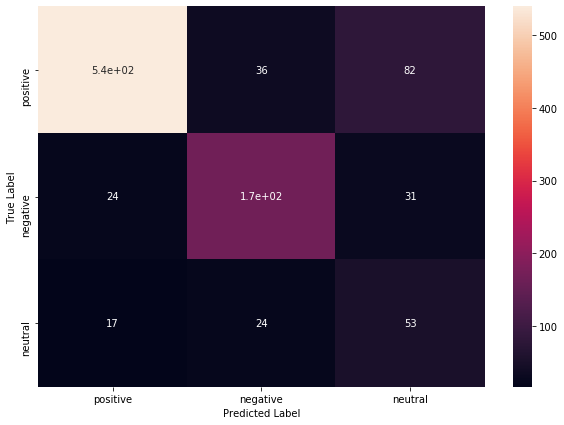

In [17]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.detach().numpy(), predictions_test.detach().numpy().argmax(-1))

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()